In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.feature_selection import mutual_info_classif

In [2]:
#load the dataset, column names are in the second row
df = pd.read_csv('churn_data.csv', header=1)

In [3]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
df.shape

(3333, 21)

In [5]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [6]:
#check the dtype of each column. There are no missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [7]:
#check for duplicates, which there are none
df.duplicated().sum()

0

In [8]:
#add column that combines the total calls
total_calls = df['total day calls'] + df['total eve calls'] + df['total night calls']
df.insert(7, 'total calls', total_calls)

In [9]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total calls,total day minutes,total day calls,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,300,265.1,110,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,329,161.6,123,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,328,243.4,114,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,248,299.4,71,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,356,166.7,113,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [10]:
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [11]:
churn_rate = df['churn'].value_counts() / len(df['churn']) * 100 
churn_rate

False    85.508551
True     14.491449
Name: churn, dtype: float64

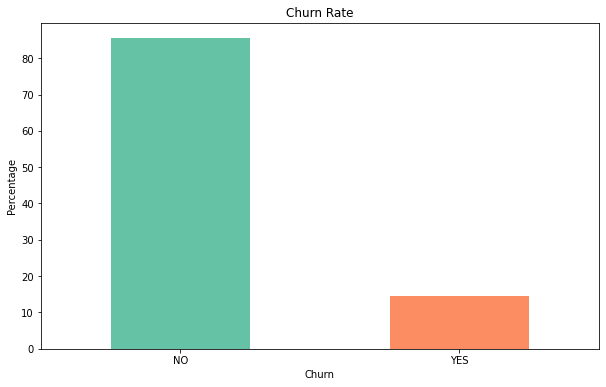

In [12]:
#plot the churn rate
fig, ax = plt.subplots(figsize=(10, 6)) 
colors = sns.color_palette('Set2')
churn_rate.plot(kind='bar', ax=ax, color=colors)
ax.set_xlabel('Churn')
ax.set_ylabel('Percentage')
ax.set_title('Churn Rate')
ax.set_xticklabels(['NO', 'YES'], rotation=0)
plt.show()

In [13]:
categoric = ['state', 'area code', 'voice mail plan', 'international plan']

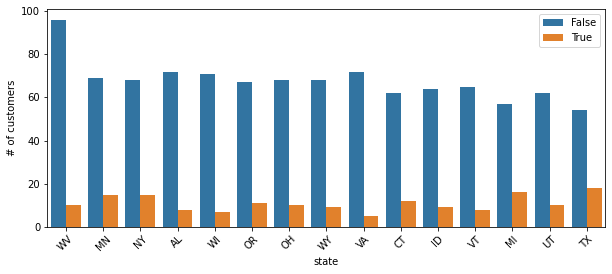

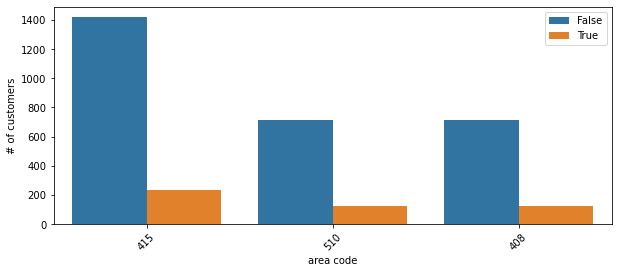

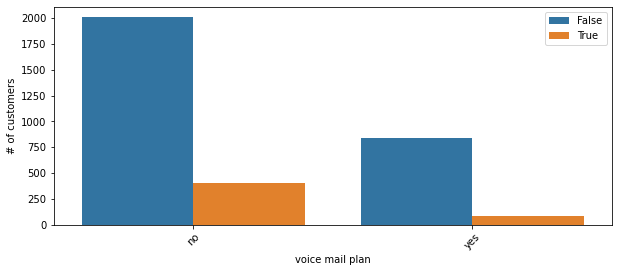

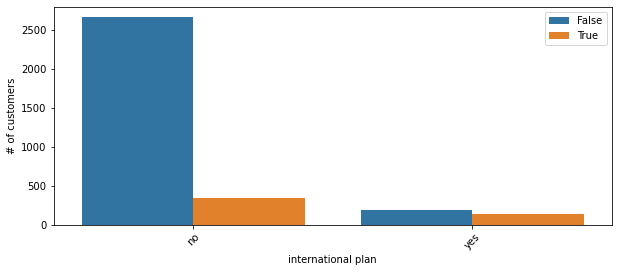

In [14]:
for i in categoric:
    plt.figure(figsize=(10,4))
    sns.countplot(x=i, hue="churn", data=df,order= df[i].value_counts().iloc[0:15].index)
    plt.xticks(rotation=45)
    plt.ylabel('# of customers')
    plt.legend(loc="upper right")
    plt.show()

In [15]:
churn_per_state = df.groupby('state')['churn'].sum().sort_values(ascending=False)
churn_per_state.head()

state
TX    18
NJ    18
MD    17
MI    16
NY    15
Name: churn, dtype: int64

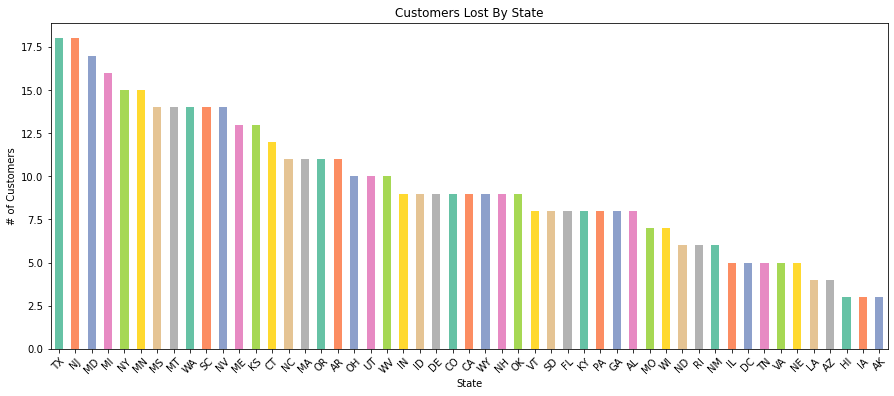

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
churn_per_state.plot(kind='bar', ax=ax, color=colors)
ax.set_xlabel('State')
ax.set_ylabel('# of Customers')
ax.set_title('Customers Lost By State')
ax.set_xticklabels(churn_per_state.index.tolist(), rotation=45)
plt.show()

In [17]:
plan_columns = ['international plan', 'voice mail plan']
for c in plan_columns:
    df.loc[df[c] == 'no', c] = 0
    df.loc[df[c] == 'yes', c] = 1

In [18]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total calls,total day minutes,total day calls,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,0,1,25,300,265.1,110,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,0,1,26,329,161.6,123,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,0,0,0,328,243.4,114,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,1,0,0,248,299.4,71,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,1,0,0,356,166.7,113,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
